# Choose the CPU cores number you want to use

In [1]:
import ray
ray.init(num_cpus=50, num_gpus=1)

2020-11-08 16:47:10,423	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '128.10.130.25',
 'raylet_ip_address': '128.10.130.25',
 'redis_address': '128.10.130.25:6379',
 'object_store_address': '/tmp/ray/session_2020-11-08_16-47-09_303808_6164/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-08_16-47-09_303808_6164/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-11-08_16-47-09_303808_6164',
 'metrics_export_port': 50794}

# Prepare

In [2]:
import CoRec
import gym
import numpy as np

import stable_baselines3 as sb3
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from ray import tune

# Reward is simply set as the number of safe steps

In [3]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, r):
        if r <= -1:
            r = 0
        else:
            r += 0.1

        return r

# Hyper-parameters Range

In [4]:
def ppo_hyper(**kwargs): return kwargs

config = ppo_hyper(
    learning_rate=tune.loguniform(1e-6, 0.01),
    n_steps=tune.choice([256, 512, 1024, 2048, 4096]),
    batch_size=tune.choice([32, 64, 128, 256, 512, 1024, 2048]),
    n_epochs=tune.randint(4, 32),
    gamma=tune.uniform(0.95, 1),
    gae_lambda=tune.uniform(0.95, 0.999),
    clip_range=tune.uniform(0.01, 0.5),
    clip_range_vf=None,
    ent_coef=0.05,
    vf_coef=tune.uniform(0.2, 0.8),
    max_grad_norm=0.5,
    use_sde=False,
    sde_sample_freq=-1,
    target_kl=None,
    seed=1
)
    
config

{'learning_rate': <ray.tune.sample.Float at 0x7f6063cbef28>,
 'n_steps': <ray.tune.sample.Categorical at 0x7f6063cbef98>,
 'batch_size': <ray.tune.sample.Categorical at 0x7f6063cd9080>,
 'n_epochs': <ray.tune.sample.Integer at 0x7f6063cd9048>,
 'gamma': <ray.tune.sample.Float at 0x7f6063cd9128>,
 'gae_lambda': <ray.tune.sample.Float at 0x7f6063cd9198>,
 'clip_range': <ray.tune.sample.Float at 0x7f6063cd9208>,
 'clip_range_vf': None,
 'ent_coef': 0.05,
 'vf_coef': <ray.tune.sample.Float at 0x7f6063cd9278>,
 'max_grad_norm': 0.5,
 'use_sde': False,
 'sde_sample_freq': -1,
 'target_kl': None,
 'seed': 1}

# Train
Error can happen because numerical instability in the model itself.

In [5]:
def env_func(): return RewardWrapper(gym.make("F16GCAS-v3"))
env = make_vec_env(env_func, n_envs=4)

In [6]:
class ReportCallback(sb3.common.callbacks.BaseCallback):
    def __init__(self, verbose=0):
        super(ReportCallback, self).__init__(verbose)
        
    def _on_rollout_end(self) -> None:
        ep_rewards = [ep_info["r"] for ep_info in self.model.ep_info_buffer]
        ep_rew_mean = np.mean(ep_rewards)
        tune.report(ep_rew = ep_rew_mean)
    
    def _on_step(self) -> bool:
        return True
    
def F16_train(config):
    callback = ReportCallback()
    model = PPO(MlpPolicy, env, verbose=1, **config)
    model.learn(total_timesteps=250000, callback=callback)
    model.save("ppo_f16")
    
analysis = tune.run(F16_train, config=config, num_samples=50, verbose=1, metric="ep_rew", mode="max", raise_on_failed_trial=False)

Trial name,status,loc,batch_size,clip_range,gae_lambda,gamma,learning_rate,n_epochs,n_steps,vf_coef,iter,total time (s),ep_rew
F16_train_f6691_00000,TERMINATED,,64,0.399357,0.974826,0.958467,0.000310136,15,4096,0.675575,16,507.287,145.855
F16_train_f6691_00001,TERMINATED,,64,0.228455,0.997095,0.985297,6.84322e-06,20,4096,0.333149,16,566.272,64.3024
F16_train_f6691_00002,TERMINATED,,256,0.29588,0.989374,0.988052,0.000897752,14,512,0.214814,123,346.3,123.863
F16_train_f6691_00003,TERMINATED,,256,0.459967,0.967212,0.981719,0.000100976,16,4096,0.539333,16,360.076,65.1088
F16_train_f6691_00004,TERMINATED,,32,0.410424,0.95313,0.951275,0.000136309,23,2048,0.568838,31,886.346,113.799
F16_train_f6691_00005,TERMINATED,,32,0.419924,0.992717,0.989646,0.00199258,13,512,0.476891,123,654.584,137.4
F16_train_f6691_00006,TERMINATED,,1024,0.0929171,0.951484,0.999424,5.99119e-05,5,1024,0.657444,62,293.986,62.1524
F16_train_f6691_00007,TERMINATED,,1024,0.480005,0.996851,0.976401,0.00206689,13,512,0.73131,123,307.272,186.113
F16_train_f6691_00008,TERMINATED,,1024,0.028201,0.972457,0.980487,0.000654754,5,2048,0.699594,31,291.803,64.4471
F16_train_f6691_00009,TERMINATED,,512,0.107569,0.986614,0.986601,1.91878e-06,9,2048,0.291791,31,308.29,63.6165


2020-11-08 17:03:33,467	ERROR tune.py:429 -- Trials did not complete: [F16_train_f6691_00029, F16_train_f6691_00035]


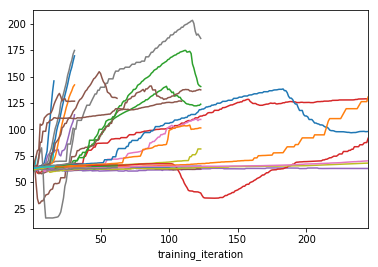

In [7]:
ax = None
dfs = analysis.trial_dataframes
for d in dfs.values():
    ax = d.plot("training_iteration", "ep_rew", ax=ax, legend=False)

In [8]:
analysis.get_best_config(metric="ep_rew", mode="max")

{'learning_rate': 0.00206688749886668,
 'n_steps': 512,
 'batch_size': 1024,
 'n_epochs': 13,
 'gamma': 0.9764012263343685,
 'gae_lambda': 0.9968508134729466,
 'clip_range': 0.4800050688503297,
 'clip_range_vf': None,
 'ent_coef': 0.05,
 'vf_coef': 0.7313102788519206,
 'max_grad_norm': 0.5,
 'use_sde': False,
 'sde_sample_freq': -1,
 'target_kl': None,
 'seed': 1}

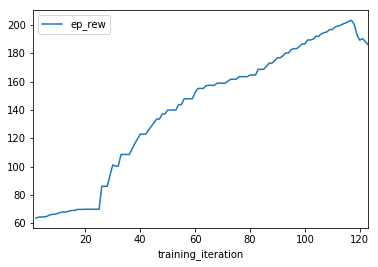

In [10]:
analysis.best_dataframe.plot("training_iteration", "ep_rew")

# Compare with TR-KFAC

Training is very sensitive to hyper-parameters. Is there any theoretical results to show why TR-KFAC will be better.